In [13]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import datetime
import os, sys, glob


# Read and Analyze Labels

In [14]:
labels = pd.read_csv('./file_ovr.csv', sep=",", header=None)
labels.head()

,0,1
0,./imgs/8758.jpg,66
1,./imgs/7367.jpg,67
2,./imgs/14596.jpg,61
3,./imgs/7393.jpg,67
4,./imgs/952.jpg,77


In [15]:
labels.describe()

,1
count,16908.000000
mean,66.315413
std,6.590548
min,51.000000
25%,62.000000
50%,66.000000
75%,71.000000
max,93.000000


# Dataframe to Numpy Array

In [16]:
labels_np = labels.values
print(labels_np[:5])

[['./imgs/8758.jpg' 66]
 ['./imgs/7367.jpg' 67]
 ['./imgs/14596.jpg' 61]
 ['./imgs/7393.jpg' 67]
 ['./imgs/952.jpg' 77]]


# Read Images

In [17]:
imgs = np.empty((len(labels_np), 120, 120, 3), dtype=np.uint8)

for i, (img_filename, rating) in enumerate(labels_np):
    print(img_filename)
    img = cv2.imread(img_filename)
    
    if img.shape[0] != 120 or img.shape[1] != 120:
        print(img_filename)
        
    imgs[i] = img

/imgs/12356.jpg
./imgs/7469.jpg
./imgs/5127.jpg
./imgs/8919.jpg
./imgs/1436.jpg
./imgs/739.jpg
./imgs/11137.jpg
./imgs/2892.jpg
./imgs/4076.jpg
./imgs/5842.jpg
./imgs/17006.jpg
./imgs/17947.jpg
./imgs/1777.jpg
./imgs/2424.jpg
./imgs/3657.jpg
./imgs/18294.jpg
./imgs/17254.jpg
./imgs/11040.jpg
./imgs/10457.jpg
./imgs/6561.jpg
./imgs/542.jpg
./imgs/11600.jpg
./imgs/6764.jpg
./imgs/8151.jpg
./imgs/1501.jpg
./imgs/15207.jpg
./imgs/3436.jpg
./imgs/18423.jpg
./imgs/1459.jpg
./imgs/288.jpg
./imgs/176.jpg
./imgs/17096.jpg
./imgs/6056.jpg
./imgs/5973.jpg
./imgs/12788.jpg
./imgs/2493.jpg
./imgs/8230.jpg
./imgs/14909.jpg
./imgs/10462.jpg
./imgs/966.jpg
./imgs/5262.jpg
./imgs/6488.jpg
./imgs/13036.jpg
./imgs/15892.jpg
./imgs/12158.jpg
./imgs/13260.jpg
./imgs/10107.jpg
./imgs/8657.jpg
./imgs/11703.jpg
./imgs/17187.jpg
./imgs/8303.jpg
./imgs/6501.jpg
./imgs/16614.jpg
./imgs/16111.jpg
./imgs/7865.jpg
./imgs/10763.jpg
./imgs/6672.jpg
./imgs/7676.jpg
./imgs/517.jpg
./imgs/16644.jpg
./imgs/12678.jpg
./im

# Split Train and Validation Dataset

In [18]:
x_train, x_val, y_train, y_val = train_test_split(imgs, labels_np[:, 1], test_size=0.1)
np.save('./train/x_train.npy', x_train)
np.save('./train/x_val.npy', x_val)
np.save('./train/y_train.npy', y_train)
np.save('./train/y_val.npy', y_val)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(15217, 120, 120, 3) (1691, 120, 120, 3)
(15217,) (1691,)


# Load Dataset

In [19]:
x_train = np.load('./train/x_train.npy',allow_pickle=True).astype(np.int)
y_train = np.load('./train/y_train.npy',allow_pickle=True).astype(np.int)
x_val = np.load('./train/x_val.npy',allow_pickle=True).astype(np.int)
y_val = np.load('./train/y_val.npy',allow_pickle=True).astype(np.int)

# Plot Samples

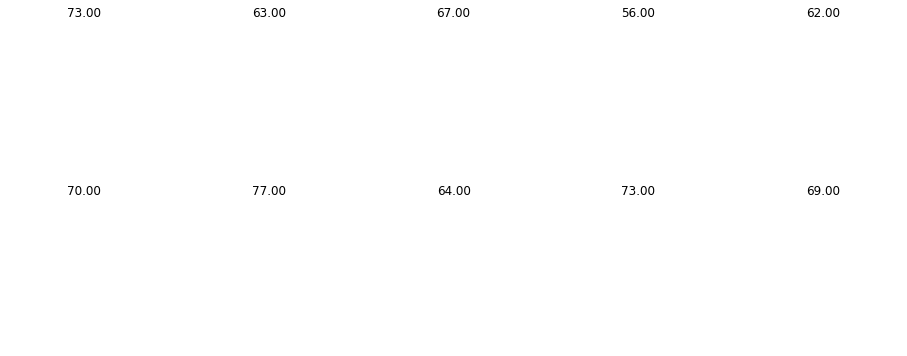

In [20]:
plt.figure(figsize=(16, 6))
for i, img in enumerate(x_train[:10]):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title('%.2f' % y_train[i])
    '''
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    '''

# Data Augmentation

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow(
    x=x_train, y=y_train,
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x=x_val, y=y_val,
    batch_size=32,
    shuffle=False
)

# Plot Augmented Images

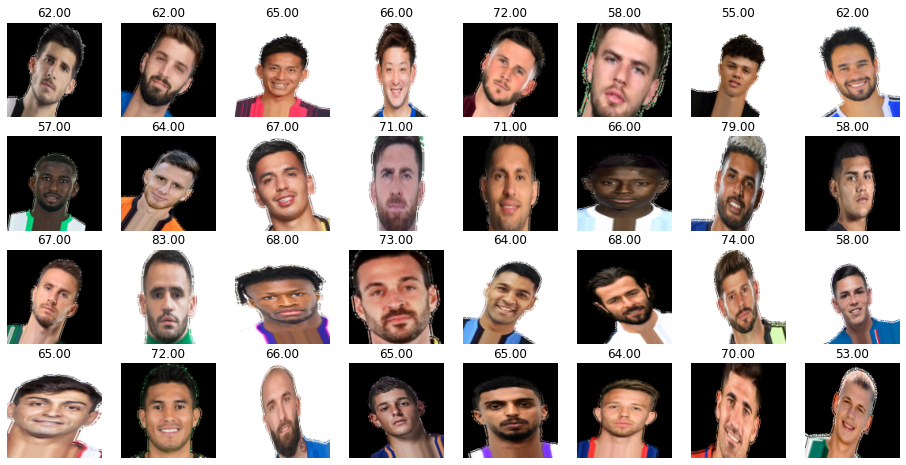

In [22]:
augs = train_generator.__getitem__(8)

plt.figure(figsize=(16, 8))
for i, img in enumerate(augs[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f' % augs[1][i])
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

# Create Model

In [23]:
inputs = Input(shape=(120, 120, 3))

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Conv2D(32, kernel_size=3, strides=1, padding='same')(net)
net = LeakyReLU()(net)
net = MaxPooling2D(pool_size=2)(net)

net = Flatten()(net)

net = Dense(256)(net)
net = Activation('relu')(net)
net = Dense(128)(net)
net = Activation('relu')(net)
net = Dense(1)(net)
outputs = Activation('linear')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 120, 32)      896       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 60, 60, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0   

# Train

In [24]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit_generator(
    train_generator, epochs=10, validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('models/%s.h5' % (start_time), monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    ]
)

/home/sjh/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/10
476/476 [==============================] - 69s 144ms/step - loss: 12.8748 - val_loss: 6.7261

Epoch 00001: val_loss improved from inf to 6.72612, saving model to models/2021_03_28_13_59_05.h5
Epoch 2/10
476/476 [==============================] - 65s 136ms/step - loss: 5.9069 - val_loss: 5.7329

Epoch 00002: val_loss improved from 6.72612 to 5.73292, saving model to models/2021_03_28_13_59_05.h5
Epoch 3/10
476/476 [==============================] - 65s 137ms/step - loss: 5.9604 - val_loss: 6.2253

Epoch 00003: val_loss did not improve from 5.73292
Epoch 4/10
476/476 [==============================] - 64s 134ms/step - loss: 5.6768 - val_loss: 5.8327

Epoch 00004: val_loss did not improve 

# Evaluate Validation Dataset

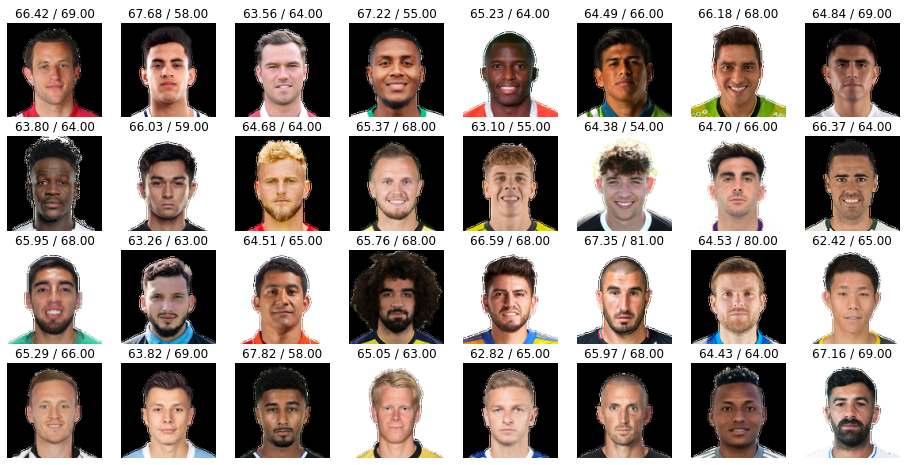

In [25]:
model = load_model('models/2021_03_28_01_12_07.h5')

val_data = val_generator.__getitem__(0)

preds = model.predict(val_data[0])

plt.figure(figsize=(16, 8))
for i, img in enumerate(val_data[0]):
    plt.subplot(4, 8, i+1)
    plt.title('%.2f / %.2f' % (preds[i], val_data[1][i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

# Test Model with Wild Dataset

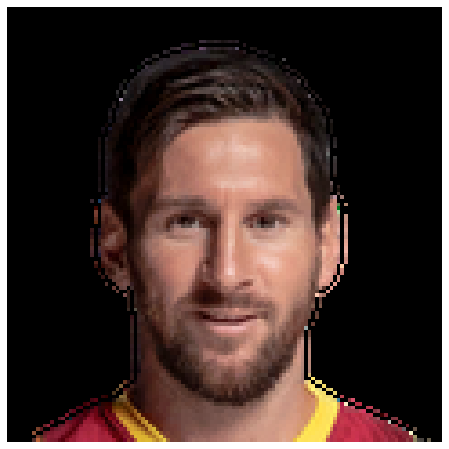

In [26]:
img_test_list = glob.glob('imgs/1.jpg')

imgs_test_resized = []

plt.figure(figsize=(16, 8))
for i, img_path in enumerate(img_test_list):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (120, 120))

    plt.subplot(1, len(img_test_list), i+1)
    plt.axis('off')
    img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())
    
    img_resized = img_resized.astype(np.float32) / 255.
    imgs_test_resized.append(img_resized)

imgs_test_resized = np.array(imgs_test_resized, dtype=np.float32)

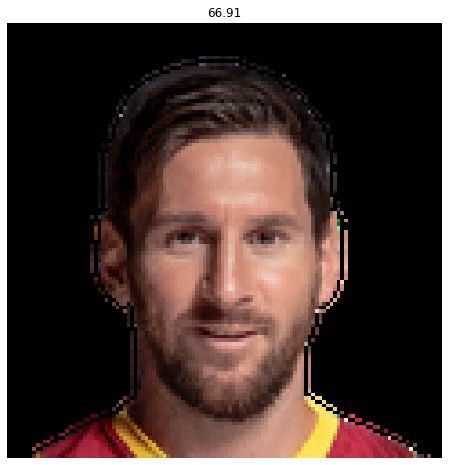

In [27]:
preds = model.predict(imgs_test_resized)

plt.figure(figsize=(16, 8))
for i, img in enumerate(imgs_test_resized):
    plt.subplot(1, len(imgs_test_resized), i+1)
    plt.title('%.2f' % (preds[i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

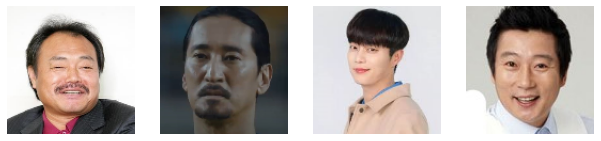

In [28]:
img_test_list = sorted(glob.glob('./celebs/*.jpg'))

imgs_test_resized = []

plt.figure(figsize=(16, 6))
for i, img_path in enumerate(img_test_list):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (120, 120))

    plt.subplot(2, 6, i+1)
    plt.axis('off')
    img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())
    
    img_resized = img_resized.astype(np.float32) / 255.
    imgs_test_resized.append(img_resized)

imgs_test_resized = np.array(imgs_test_resized, dtype=np.float32)

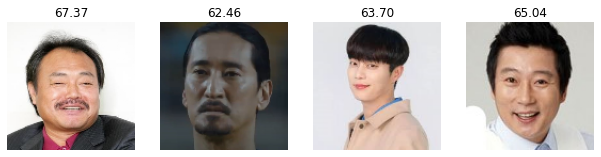

In [29]:
preds = model.predict(imgs_test_resized)

plt.figure(figsize=(16, 6))
for i, img in enumerate(imgs_test_resized):
    plt.subplot(2, 6, i+1)
    plt.title('%.2f' % (preds[i]))
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img.squeeze())

In [30]:
plt.plot(labels.head())

TypeError: unhashable type: 'numpy.ndarray'